# *Portfolio Optimization Project Using Modern Portfolio Theory (MPT) and Markowitz Model

Goal: Constructing a moderately aggressive, risk-aware portfolio for a long-term investor seeking stable returns with exposure to growth.

Importing Required liabraries 

In [56]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import time  # for handling rate limits



In [58]:
!pip show alpha_vantage

Name: alpha_vantage
Version: 3.0.0
Summary: Python module to get stock data from the Alpha Vantage Api
Home-page: https://github.com/RomelTorres/alpha_vantage
Author: Romel J. Torres
Author-email: romel.torres@gmail.com
License: MIT
Location: /opt/anaconda3/lib/python3.12/site-packages
Requires: aiohttp, requests
Required-by: 


# Section 1: Defining Tickers and Time Range 

In [59]:
#Defining the list of tickers for my choosen asstes (EFTs+Stocks)
tickers = ["SPY", "AGG", "EFA", "MSFT", "JPM", "NVDA", "JNJ", "PG"]

In [60]:
#Setting the end date to today
end_date = datetime.today()

In [103]:
#Setting the start date to 5 years ago
start_date= end_date - timedelta(days = 5*365)
print(start_date)

2020-08-12 14:42:50.311250


In [104]:
api_key = 'OJ8Y2GIWOSA9HYQ8' 

# Initialize Alpha Vantage
ts = TimeSeries(key=api_key, output_format='pandas')


# Section 2: Downloading adjusted close price 

In [105]:
#Downnloading close price for all tickers at once
adj_close_df = pd.DataFrame()

In [110]:
def get_daily_data(ticker):
    # This is the free endpoint
    data, _ = ts.get_daily(symbol=ticker, outputsize='full')
    # Use the '4. close' column for the closing price
    return data['4. close']

In [ ]:


for ticker in tickers:
    try:
        adj_close_df[ticker] = get_daily_data(ticker)
        time.sleep(12)  # Rate limiting
    except Exception as e:
        print(f"Error with {ticker}: {str(e)}")
        continue

print(adj_close_df.dropna())

In [112]:
#displaying data frame
print(adj_close_df)

                 SPY    AGG  EFA  MSFT  JPM
date                                       
2025-08-08  637.1800  98.94  NaN   NaN  NaN
2025-08-07  632.2500  99.13  NaN   NaN  NaN
2025-08-06  632.7800  99.21  NaN   NaN  NaN
2025-08-05  627.9700  99.25  NaN   NaN  NaN
2025-08-04  631.1700  99.22  NaN   NaN  NaN
...              ...    ...  ...   ...  ...
1999-11-05  137.8750    NaN  NaN   NaN  NaN
1999-11-04  136.5312    NaN  NaN   NaN  NaN
1999-11-03  135.5000    NaN  NaN   NaN  NaN
1999-11-02  134.5937    NaN  NaN   NaN  NaN
1999-11-01  135.5625    NaN  NaN   NaN  NaN

[6482 rows x 5 columns]


# Section 3: Calculating Lognormal Returns

In [66]:
#Calculating lognormal returns for each ticker 

price_ratio = adj_close_df / adj_close_df.shift(1)  
log_return = np.log(price_ratio)

Dropping any Mssing Values 

In [67]:
log_return=log_return.dropna()

# Section 4 : Calculate Covariance Matrix 

In [68]:
# Calculating covariance 
cov_matrix = log_return.cov()*252
print(cov_matrix)

           SPY       AGG       EFA      MSFT       JPM      NVDA       JNJ  \
SPY   0.035561 -0.000139  0.034479  0.036607  0.047707  0.054981  0.018205   
AGG  -0.000139  0.002844  0.000233 -0.000063 -0.002383 -0.000049 -0.000080   
EFA   0.034479  0.000233  0.099294  0.034080  0.048408  0.050519  0.017902   
MSFT  0.036607 -0.000063  0.034080  0.071737  0.042030  0.065916  0.017884   
JPM   0.047707 -0.002383  0.048408  0.042030  0.123361  0.060320  0.022530   
NVDA  0.054981 -0.000049  0.050519  0.065916  0.060320  0.607001  0.017129   
JNJ   0.018205 -0.000080  0.017902  0.017884  0.022530  0.017129  0.029488   
PG    0.019447  0.000050  0.019243  0.019747  0.024137  0.021301  0.016784   

            PG  
SPY   0.019447  
AGG   0.000050  
EFA   0.019243  
MSFT  0.019747  
JPM   0.024137  
NVDA  0.021301  
JNJ   0.016784  
PG    0.053938  


Confirming log vs. simple return differences are negligible (<0.01%)

In [70]:
# Validating Return Type Assumptions

log_means = log_return.mean()
simple_means = adj_close_df.pct_change().mean()

# Comparing differences
difference = (np.exp(log_means + 0.5*log_return.var()) - 1) - simple_means
print("Difference (%):\n", difference * 100)  # Convert to percentage

if (abs(difference) > 0.0001).any():  # If any difference > 0.01%
    print("[WARNING] Large return-type differences detected for:", 
          difference[difference > 0.0001].index.tolist())
else:
    print("Validation passed: return-type differences < 0.01%")


Difference (%):
 SPY    -0.010286
AGG     0.000180
EFA    -0.002844
MSFT   -0.034507
JPM    -0.023798
NVDA   -0.108841
JNJ    -0.021552
PG     -0.006989
dtype: float64
[WARNING] Large return-type differences detected for: []


/var/folders/yw/t9jz6sd55w71t2th98wmv_180000gn/T/ipykernel_1688/3060059575.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  simple_means = adj_close_df.pct_change().mean()


# Section 5: Defining Portfolio Performance Metrics 

In [71]:
#calculating the portfolio standard deviation

def standard_deviation (weights, cov_matrix):
    """Annualized portfolio volatility (standard deviation)."""
    variance = weights.T @cov_matrix @weights
    return np.sqrt(variance)

In [72]:
#calculating the expected portfolio return
def expected_return (weights, log_return):
    """Annualized expected portfolio return."""
    return np.sum(log_return.mean()*weights)*252

In [75]:
# calculating sharpe ratio 

def sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Risk-adjusted return metric (higher = better)."""
    er = expected_return(weights, log_return)
    sd = standard_deviation(weights, cov_matrix)
    return (er - risk_free_rate) / sd

In [90]:
risk_free_rate = 0.0427 # Set the rate as a decimal.
print(f"Risk-Free Rate: {risk_free_rate}")

Risk-Free Rate: 0.0427


In [91]:
test_weights = np.array([1/len(tickers)] * len(tickers))
print(f"Test Sharpe Ratio: {sharpe_ratio(test_weights, log_return, cov_matrix, risk_free_rate):.2f}")

Test Sharpe Ratio: -0.54


# Section 6: Portfolio Optimization 

Setting the risk- free rate 

In [92]:
# Defining the function to mimimize (negative sharpe ratio)
def negative_sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization"""
    return -sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate)

In [93]:
#Setting the constarint bounds for optimization

# RULE 1: Weights must sum to 100% (no leftover cash)

constraints = [ # Sum of weights = 100% (fully invested)
               {'type':'eq','fun': lambda weights: np.sum(weights)-1},

               # Tech sector (NVDA + MSFT) < 30% of portfolio
               {'type': 'ineq', 'fun': lambda weights: 0.3 - (weights[tickers.index("NVDA")] + weights[tickers.index("MSFT")])}
]


# Bounds: No asset <5% or >20% (diversification rule)
bounds = [(0.05, 0.20) for _ in range(len(tickers))]


In [94]:
#setting initial weights 

initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [95]:

print("Individual weights:", initial_weights)  # Should show [0.125, 0.125, ...] for 8 tickers
print("Sum of weights:", np.sum(initial_weights))  # Must be 1.0

Individual weights: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Sum of weights: 1.0


Comparing to Benchmarks 

In [96]:
#Calculating equal-weighted performance for comparison

equal_weights = np.array([1/len(tickers)]*len(tickers))
equal_return = expected_return(equal_weights, log_return)
equal_vol = standard_deviation(equal_weights, cov_matrix)
equal_sharpe = sharpe_ratio(equal_weights, log_return, cov_matrix, risk_free_rate)

In [97]:
#Optimize the weight to maximise Sharpe Ratio
optimized_results=minimize(negative_sharpe_ratio,initial_weights, args= (log_return,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)

In [98]:
#Getting Optimial weights 
optimal_weights = optimized_results.x

# Section 7: Analyze the optimal Portfolio 

In [101]:
# Print optimal weights
print('optimal_weights:')
for ticker,weight in zip(tickers,optimal_weights):
    print(f'{ticker}:{weight: .2%}')

print()
optimal_portfolio_return= expected_return(optimal_weights,log_return)
optimal_portfolio_volatility= standard_deviation(optimal_weights,cov_matrix)
optimal_sharpe_ratio= sharpe_ratio(optimal_weights,log_return,cov_matrix,risk_free_rate)

print(f"Expected Annual Return : {optimal_portfolio_return: .4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .4f}")
print(f"Sharpe Ratio : {optimal_sharpe_ratio: .4f}")

optimal_weights:
SPY: 5.00%
AGG: 20.00%
EFA: 20.00%
MSFT: 5.00%
JPM: 5.00%
NVDA: 20.00%
JNJ: 5.00%
PG: 20.00%

Expected Annual Return : -0.0426
Expected Volatility:  0.2182
Sharpe Ratio : -0.3908


# Section 7:  Visualization 

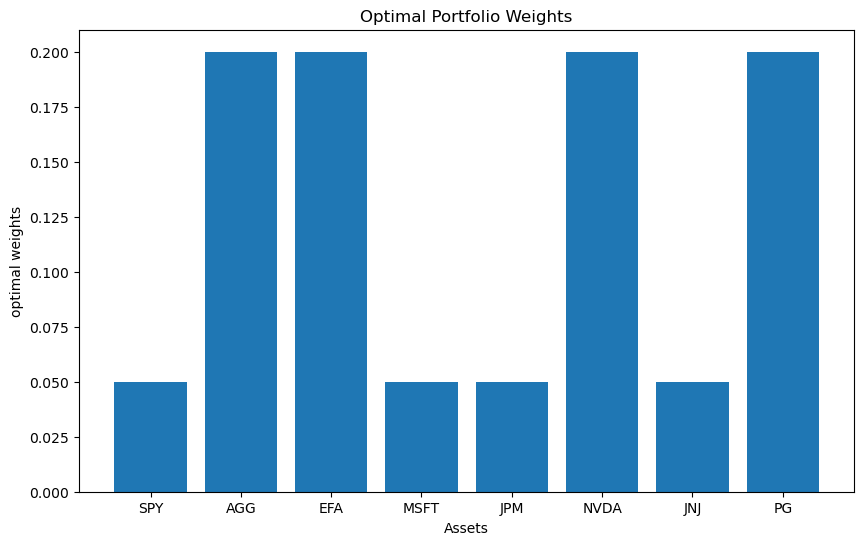

In [100]:
#Displaying the final portfolio graphically 


#importing required liabrary
import matplotlib.pyplot as plt 

#creating a vbar chart of optimal weights 
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

#Add labels and a title 
plt.xlabel('Assets')
plt.ylabel('optimal weights')
plt.title("Optimal Portfolio Weights")

#Display 
plt.show()

 
